In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
chain = np.load('../runs/chain_ha_mm_rpprior.npy')

13.043349373623602 12.33894179921061


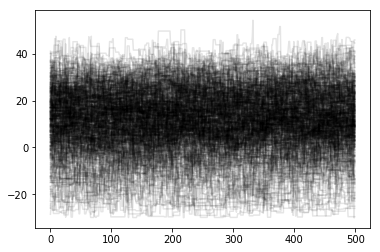

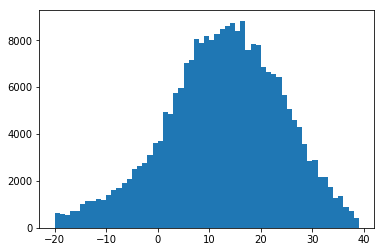

In [63]:
i = 6
clip = 2500
plt.plot(chain[0:,clip:,i].T, 'k', alpha=0.1)
print(np.median(chain[:,clip:,i]), np.std(chain[:,clip:,i]))
plt.show()

plt.hist(chain[:,clip:,i].flatten(), np.arange(-20, 40, 1))
plt.show()

In [24]:
param = chain[:,clip:,i].flatten()
lp = len(param)

boundvals = 13-10, 13+10
len(param[(param < boundvals[1]) & (param > boundvals[0])])/lp

0.610596

In [25]:
sc = np.shape(chain)
clip = 2000
igburn = chain[:,clip:,:].flatten().reshape(sc[0]*(sc[1]-clip),sc[2])

si = np.shape(igburn)
rand = np.random.randint(0, si[0], 100)

In [26]:
from scipy.interpolate import interp1d


In [27]:
import starry
time, vels, verr, ha = np.loadtxt('../data/transit.vels', usecols=[0,1,2,4], unpack=True)
time -= 2458706.5
map = starry.Map(ydeg=4, udeg=2, rv=True, lazy=False)
map.reset()

Prot = 2.85             # days
P = 8.1387              # days
e = 0.0
w = 0.0
inc = 90.0

tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0

def rmcurve(tarr, params):
    
    f = interp1d(tuse, ha, kind='cubic', fill_value=(ha[0], ha[-1]), bounds_error=False)
    
    ha_use = f(tarr)


    vsini, r, b, a, u1, u2, obl, gamma, jitter_good, t0, ha_fac = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (tarr - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tarr

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    
    trend = ha_fac * (ha_use-0.055)
    rv = rv_0 + trend + gamma
    
    return rv, trend+gamma

In [59]:
def rmcurve_mm(tarr, params):
    
    f = interp1d(tuse, ha, kind='cubic', fill_value=(ha[0], ha[-1]), bounds_error=False)
    
    ha_use = f(tarr)


    vsini, r, b, a, u1, u2, obl, gamma, jitter_good, jitter_bad, q, t0, ha_fac = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (tarr - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tarr

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    
    trend = ha_fac * (ha_use-0.055)
    rv = rv_0 + trend + gamma
    
    return rv, trend, rv_0-gamma

In [60]:
tarr = np.arange(0, 0.5, 0.001)
rv_out = np.zeros((100, len(tarr)))
trend_out = np.zeros((100, len(tarr)))
rv0_out = np.zeros((100, len(tarr)))

for i in range(100):
    rv_out[i], trend_out[i], rv0_out[i] = rmcurve_mm(tarr, igburn[rand[i]])

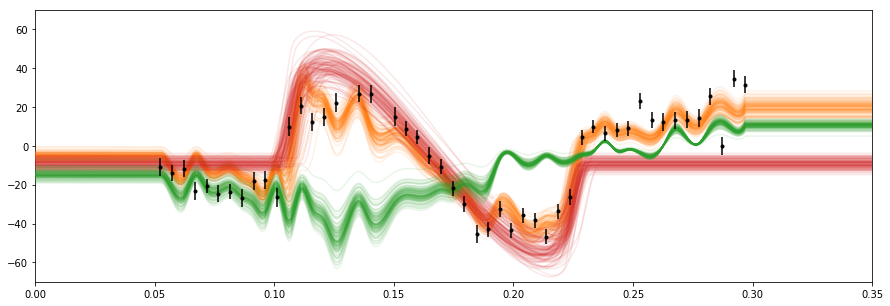

In [62]:
plt.figure(figsize=(15,5))

plt.plot(tarr, rv_out.T, 'C1', alpha=0.1, zorder=3)
plt.plot(tarr, rv0_out.T, 'C3', alpha=0.1, zorder=3)
plt.plot(tarr, trend_out.T, 'C2', alpha=0.1, zorder=3)

plt.errorbar(time, vels, yerr=verr, fmt='k.', zorder=5)

plt.ylim(-70, 70)
plt.xlim(0.0, 0.35)

plt.show()
